In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
import numpy as np
import pydl.pydlutils.spheregroup as spheregroup
import observesim.sloane as sloane
import observesim.coords as coords
import fitsio
import healpy
import astropy.io.ascii as ascii

## A very preliminary set of tiles

This notebook sets up a very preliminary set of SDSS-V tiles. Each tile will correspond to a different observation. We will set the number of tiles according to what we need to get roughly enough epoch-exposures in each area. This is not very realistic but hopefully will be useful in exploring the parameters of the problem in front of us.

## Some code for plotting the tiles

In [2]:
def set_moll():
    m = basemap.Basemap(projection='moll', lon_0=270, resolution='c')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-90., 120., 30.),
                    linewidth=0.5,
                    labels=[1, 0, 0, 0],
                    labelstyle='+/-')
    m.drawmeridians(np.arange(0., 420., 60.), linewidth=0.5)
    m.drawmapboundary()
    return(m)

def _convert_radec(m, ra, dec):
    return m(((360. - ra) + 180.) % 360., dec, inverse=False)

def plot_circle(m, ra, dec, radius, color='blue'):
    boundary = 90.
    ncirc = 16
    theta = np.arange(ncirc) * np.pi * 2. / np.float32(ncirc - 1)
    
    cra = (ra + radius / np.cos(dec * np.pi / 180.) *
                   np.cos(theta))
    cdec = dec + radius * np.sin(theta)

    nabove = np.count_nonzero(cra > boundary)
    if(nabove > 0):
        iabove = np.nonzero(cra > boundary)[0]
        (xx, yy) = _convert_radec(m, cra[iabove], cdec[iabove])
        plt.plot(xx, yy, linewidth=0.25, color=color)
            
    nbelow = np.count_nonzero(cra < boundary)
    if(nbelow > 0):
        ibelow = np.nonzero(cra < boundary)[0]
        (xx, yy) = _convert_radec(m, cra[ibelow], cdec[ibelow])
        plt.plot(xx, yy, linewidth=0.25, color=color)
    return

def plot_tile(m, ra, dec, observatory='apo'):
    if(observatory == 'apo'):
        radius = 1.5
    else:
        radius = 0.95
    plot_circle(m, ra, dec, radius, color='blue')
    plot_circle(m, ra, dec, radius / 3., color='red')

## Create basic set of sparse and dense tiles

The sparse tiles are designed to just barely link at their edges. Note that this sparse distribution leaves gaps at the center. The design here is based on the approximate coverage assuming an outer radius of 1.5 deg and inner radius of 0.5 deg. The real FPS is a bit different.

These sets of tiles cover the full sky. Further down in the notebook we carve out different parts of the sky as sparse and dense.

In [3]:
sparse_north = sloane.Sloane(n=8192)
sparse_north_area = 4. * np.pi * (180. / np.pi)**2 / np.float64(sparse_north.n)
sparse_south = sloane.Sloane(n=18752)
sparse_south_area = 4. * np.pi * (180. / np.pi)**2 / np.float64(sparse_south.n)
sparse_north.deccut(-15.)
sparse_south.deccut(-14., above=False)

8192
18752


<IPython.core.display.Javascript object>


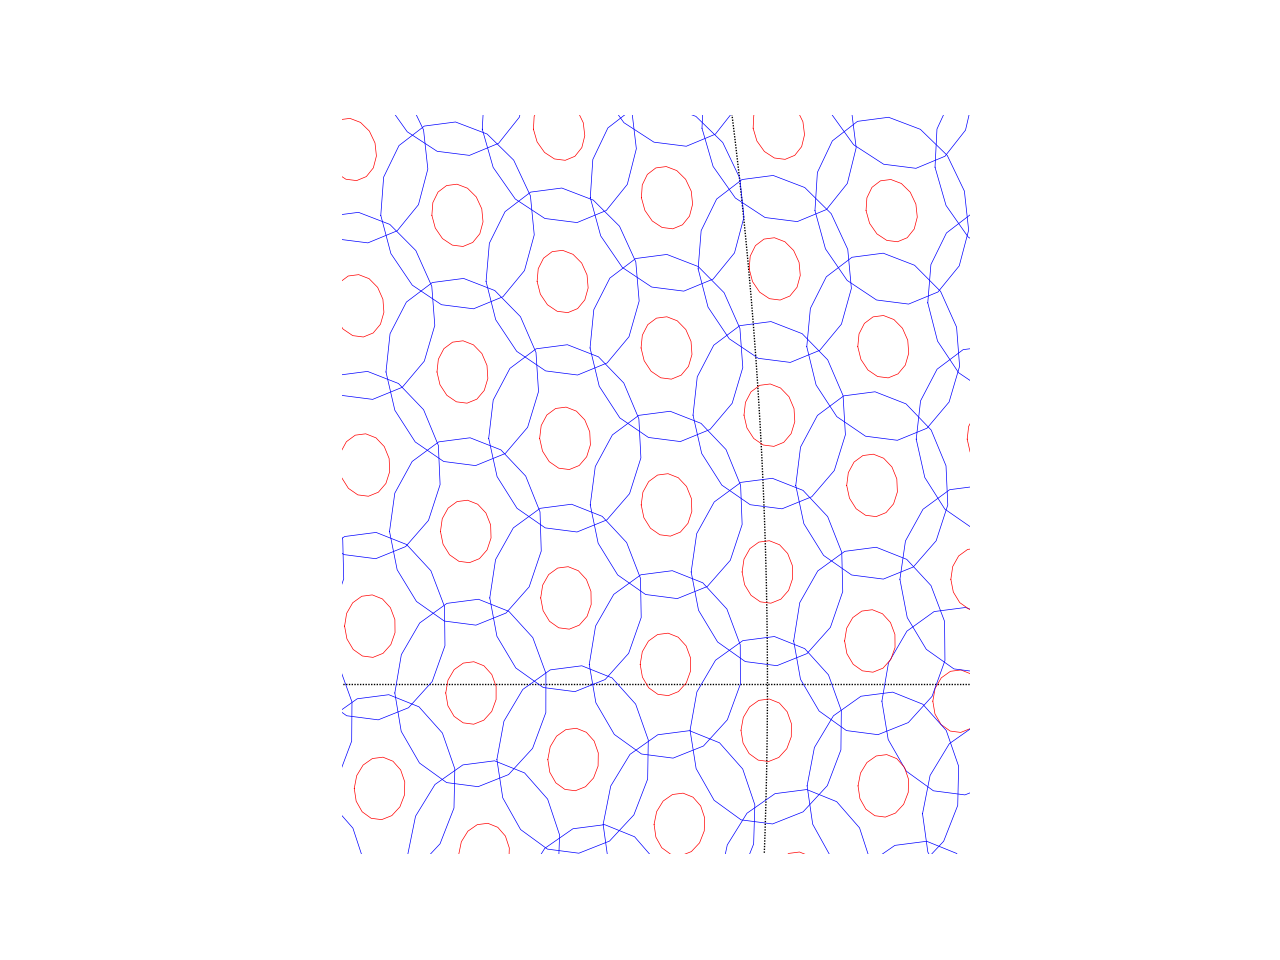

In [4]:
m = set_moll()
racen = 182.5
deccen = 2.5
cosdec = np.cos(np.pi * deccen / 180.)
size = 5.
indx = np.where((np.abs(sparse_north.ra - racen) < ((size + 3.) / cosdec)) &
                (np.abs(sparse_north.dec - deccen) < (size + 3.)))[0]
for ra, dec in zip(sparse_north.ra[indx], sparse_north.dec[indx]):
    plot_tile(m, ra, dec, observatory='apo')

The dense tiles are designed to cover all of the available area.

In [5]:
dense_north = sloane.Sloane(n=21872)
dense_north_area = 4. * np.pi * (180. / np.pi)**2 / np.float64(dense_north.n)
dense_south = sloane.Sloane(n=52922)
dense_south_area = 4. * np.pi * (180. / np.pi)**2 / np.float64(dense_south.n)
dense_north.deccut(-15.)
dense_south.deccut(-14., above=False)

21872
52922


<IPython.core.display.Javascript object>


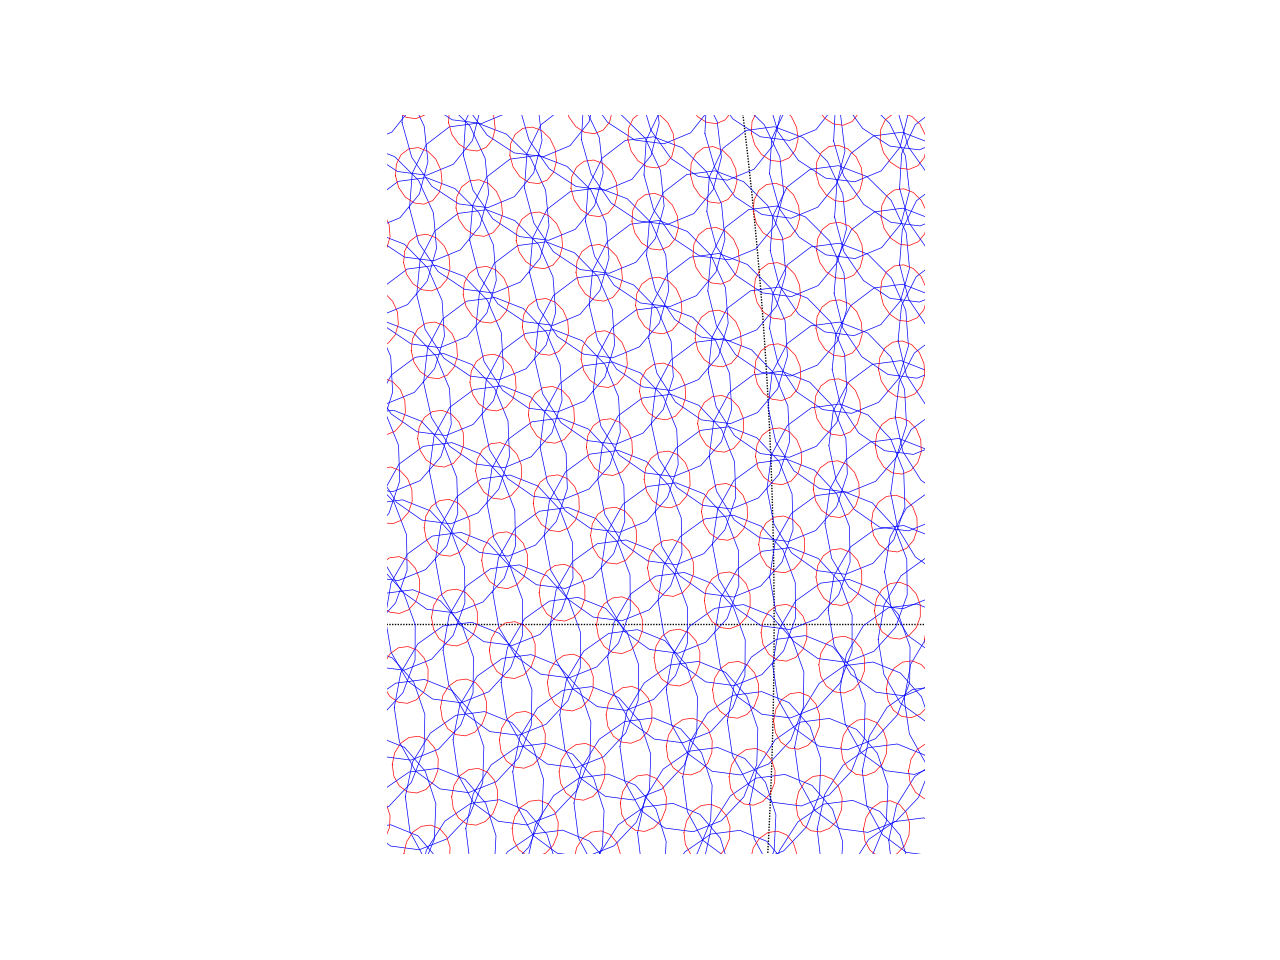

In [6]:
m = set_moll()
racen = 182.5
deccen = 2.5
cosdec = np.cos(np.pi * deccen / 180.)
size = 5.
indx = np.where((np.abs(dense_north.ra - racen) < ((size + 3.) / cosdec)) &
                (np.abs(dense_north.dec - deccen) < (size + 3.)))[0]
for ra, dec in zip(dense_north.ra[indx], dense_north.dec[indx]):
    plot_tile(m, ra, dec, observatory='apo')

## Now let's look at the targets

We will make maps of the targets, the integrated density of epoch-exposures in each healpix pixel, and the maximum number of epoch-exposures in each healpix pixel.

In [7]:
targets = fitsio.read('targets.fits')

In [8]:
nside =  32
hpix = healpy.pixelfunc.ang2pix(nside, targets['ra'], targets['dec'], lonlat=True)
ntarget = np.zeros(healpy.nside2npix(nside))
nexp = np.zeros(healpy.nside2npix(nside))
max_nexp = np.zeros(healpy.nside2npix(nside))
for pix, ne, epe in zip(hpix, targets['n_epochs'], targets['n_exp_per_epoch']):
    ntarget[pix] = ntarget[pix] + 1
    nexp[pix] = nexp[pix] + ne * epe
    if(ne * epe > max_nexp[pix]):
        max_nexp[pix] = ne * epe
dexp = nexp / healpy.nside2pixarea(nside, degrees=True)

<IPython.core.display.Javascript object>


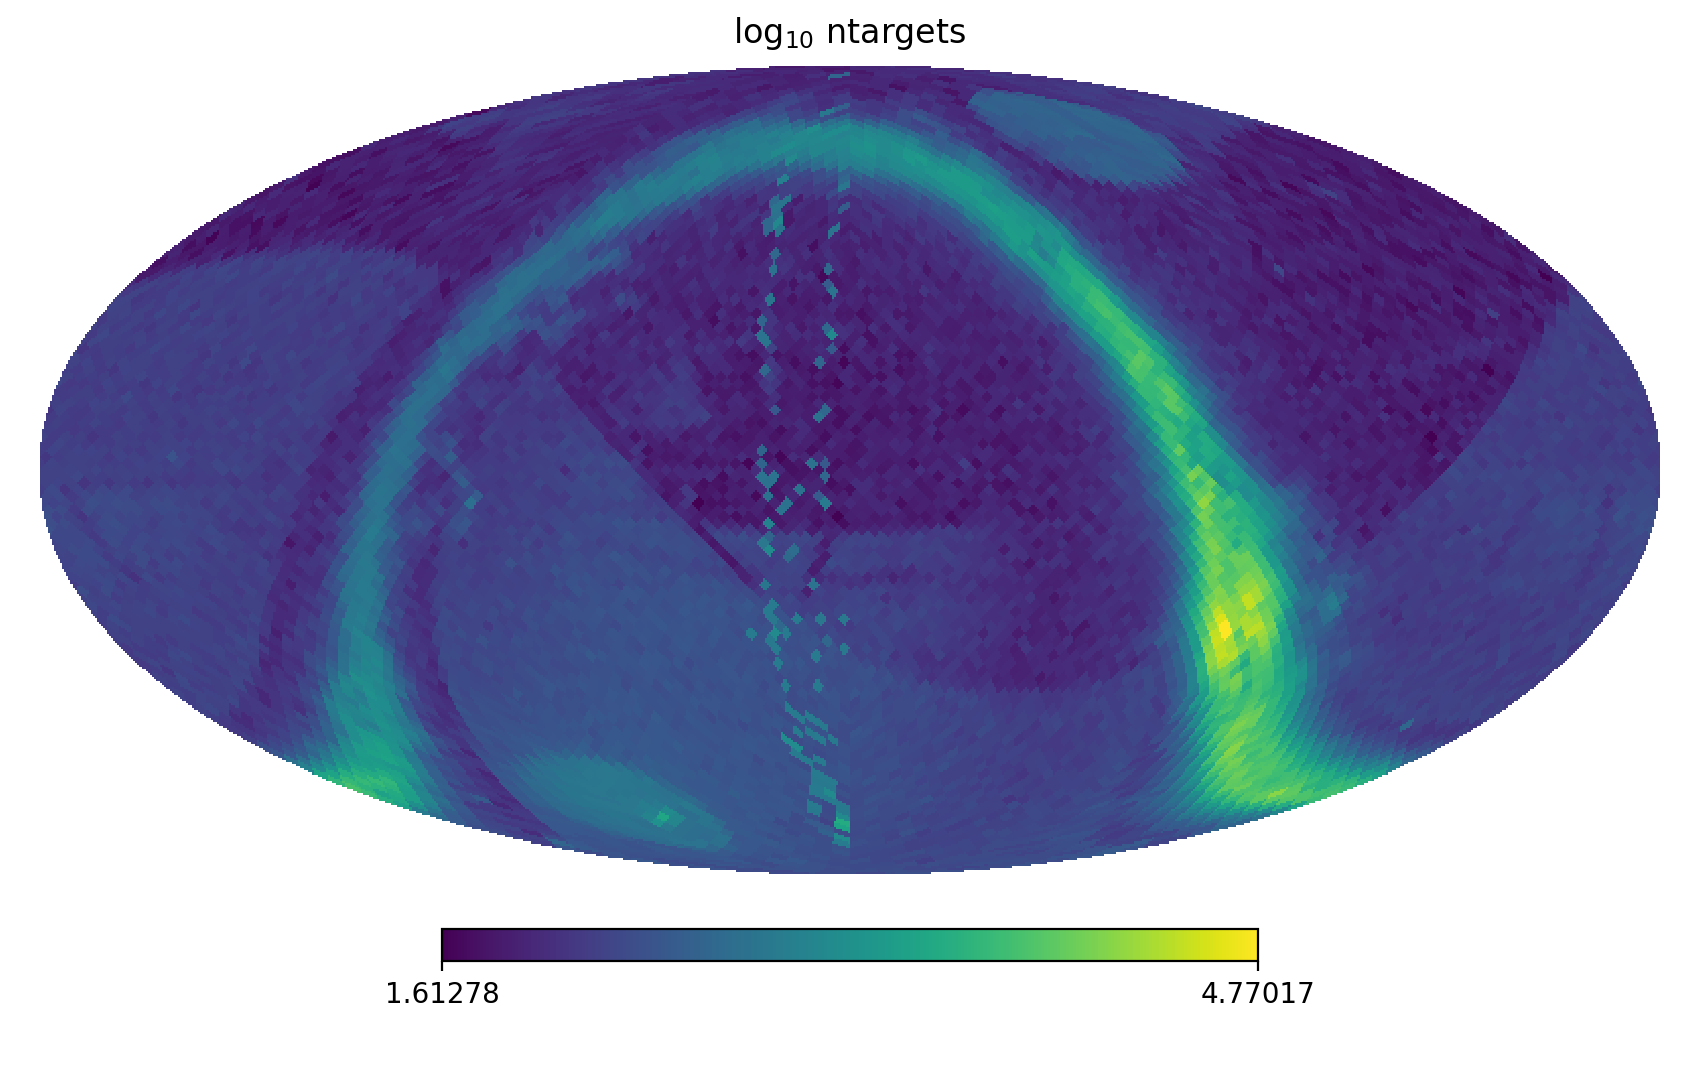

In [9]:
healpy.mollview(np.log10(ntarget), title="log$_{10}$ ntargets")

<IPython.core.display.Javascript object>


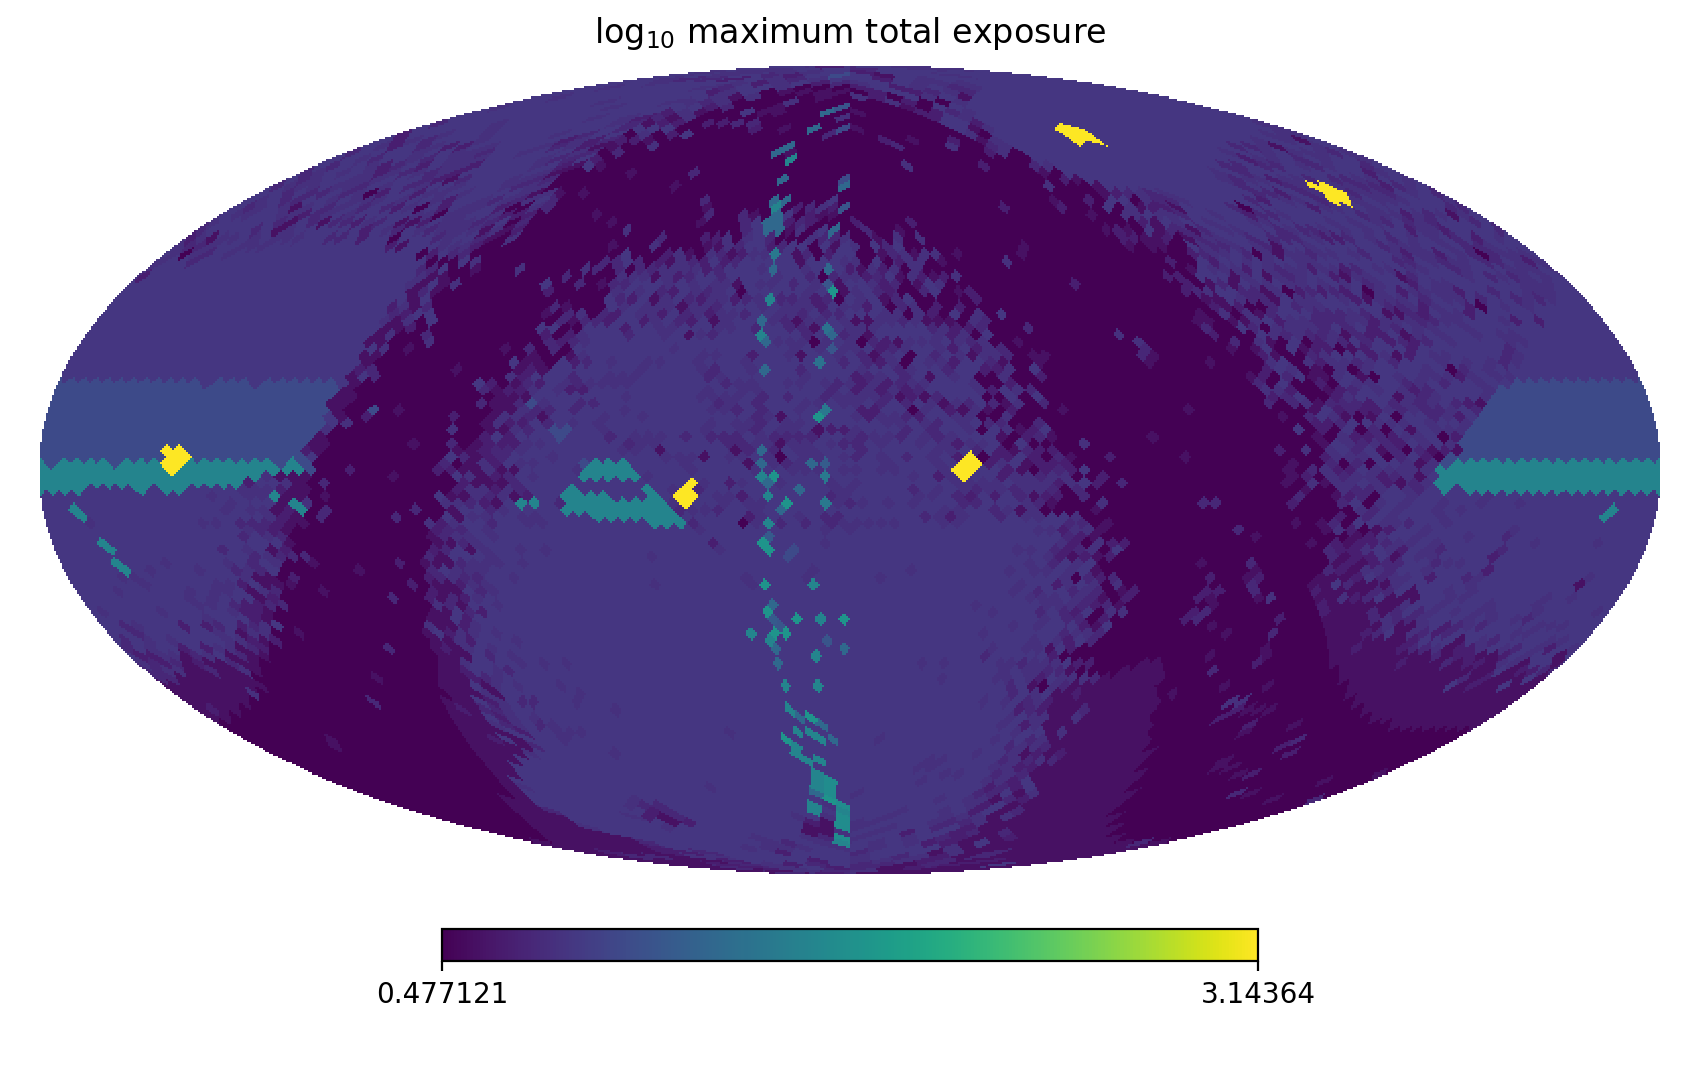

In [10]:
healpy.mollview(np.log10(max_nexp), title="log$_{10}$ maximum total exposure")

<IPython.core.display.Javascript object>


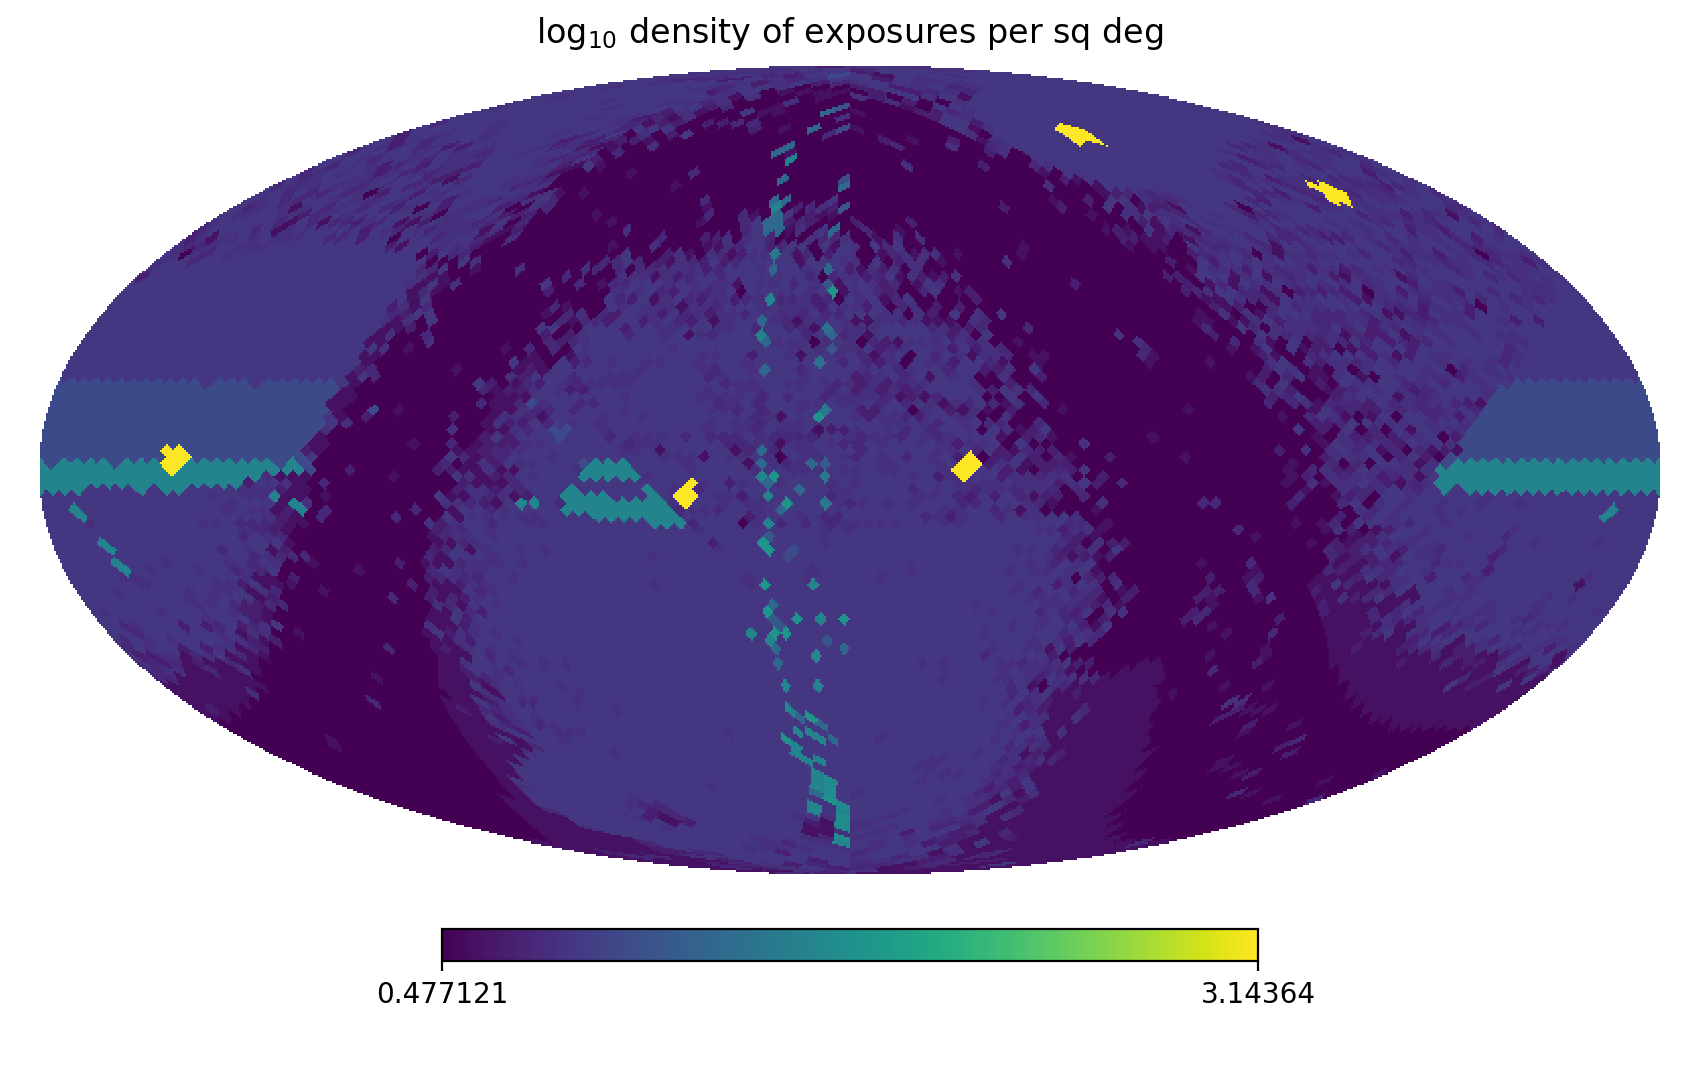

In [11]:
healpy.mollview(np.log10(max_nexp), title="log$_{10}$ density of exposures per sq deg")

In [12]:
(tl, tb) = coords.eq2gal(targets['ra'], targets['dec'])
nside = 32
hpix = healpy.pixelfunc.ang2pix(nside, tl, tb, lonlat=True)
gntarget = np.zeros(healpy.nside2npix(nside))
gnexp = np.zeros(healpy.nside2npix(nside))
for pix, ne, epe in zip(hpix, targets['n_epochs'], targets['n_exp_per_epoch']):
    gntarget[pix] = gntarget[pix] + 1
    gnexp[pix] = gnexp[pix] + ne * epe

<IPython.core.display.Javascript object>


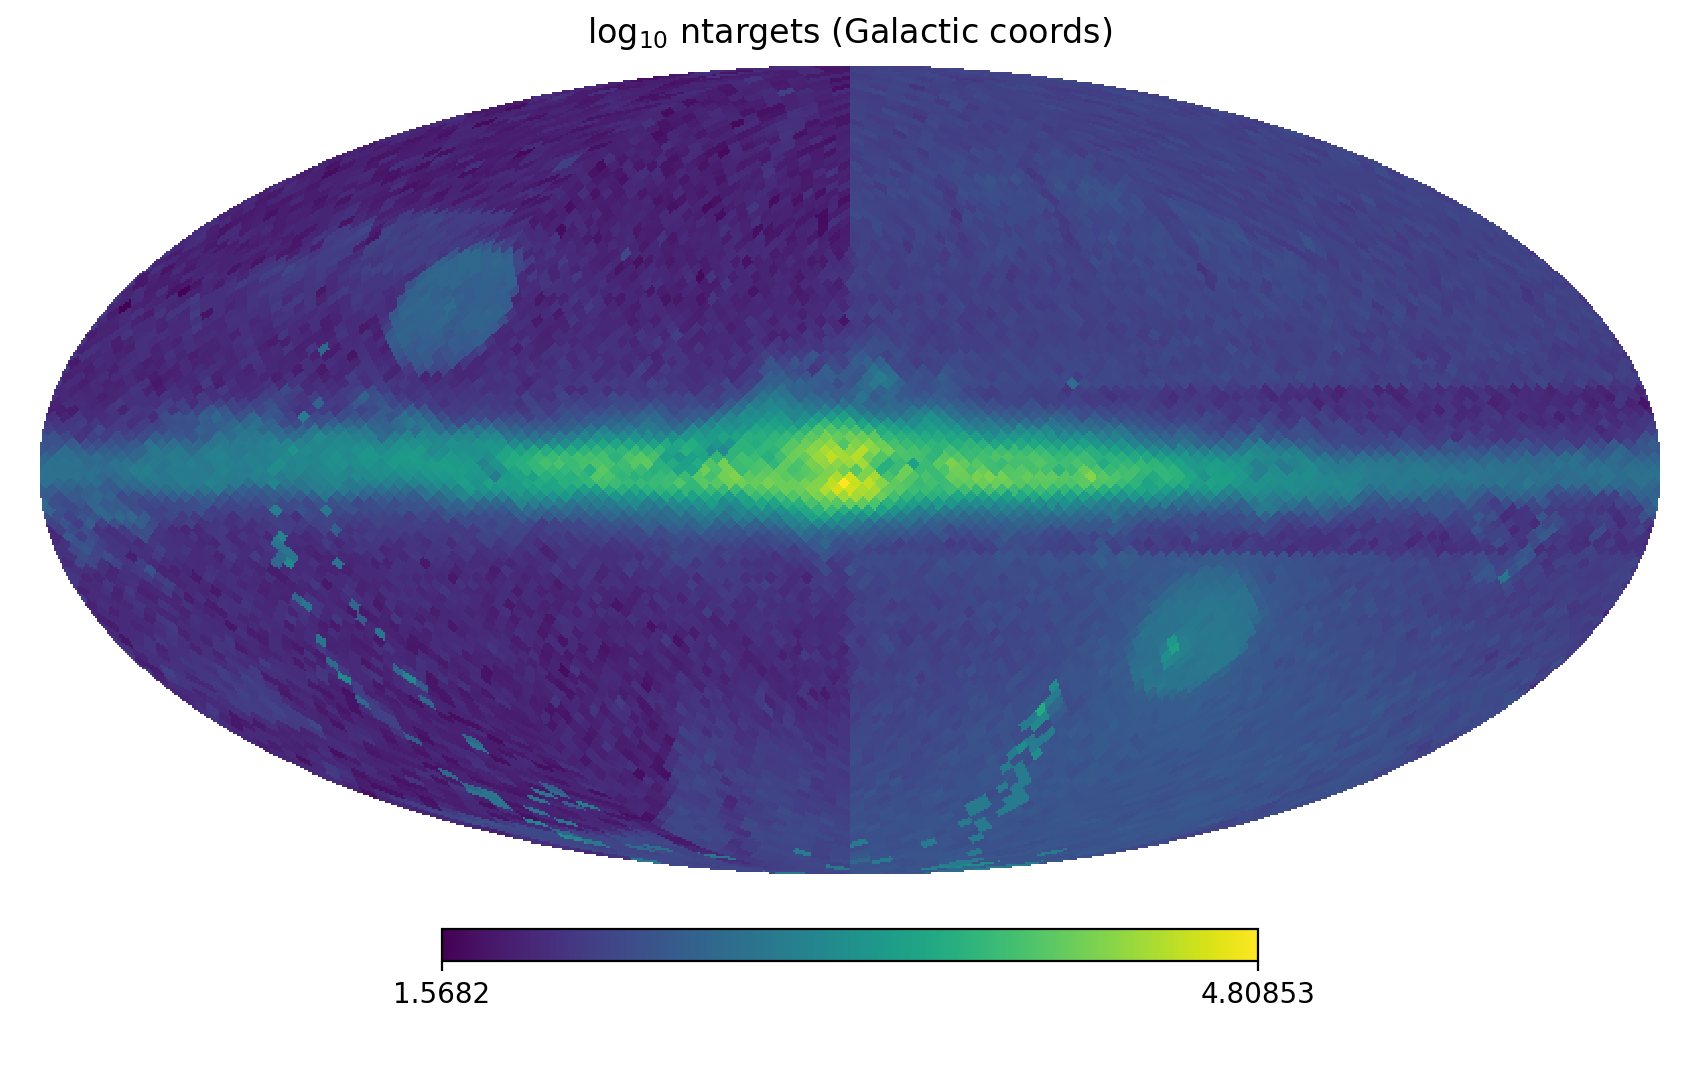

In [13]:
healpy.mollview(np.log10(gntarget), title="log$_{10}$ ntargets (Galactic coords)")

## Fields

We are now going to define a set of field positions, classified as CVZ, all-sky (eROSITA-covering and not), Galactic Plane, and RV fields. This isn't really complete.

One lesson I learned in this is that we should ask the targeting terms to provide explicit boundaries describing the coverage of their targets.

### NCVZ fields

In [14]:
(elon, elat) = coords.eq2ec(dense_north.ra, dense_north.dec)
ikeep = np.where(elat > 78.)[0]
ra_ncvz = dense_north.ra[ikeep]
dec_ncvz = dense_north.dec[ikeep]
area_ncvz = np.zeros(len(ikeep)) + dense_north_area
tiletype_ncvz = list()
for indx in np.arange(len(ikeep)):
    tiletype_ncvz.append('cvz_north')

### SCVZ fields

In [15]:
(elon, elat) = coords.eq2ec(dense_south.ra, dense_south.dec)
ikeep = np.where(elat < -78.)[0]
ra_scvz = dense_south.ra[ikeep]
dec_scvz = dense_south.dec[ikeep]
area_scvz = np.zeros(len(ikeep)) + dense_south_area
tiletype_scvz = list()
for indx in np.arange(len(ikeep)):
    tiletype_scvz.append('cvz_south')

### North galactic plane fields

In [16]:
(l, b) = coords.eq2gal(dense_north.ra, dense_north.dec)
pix = healpy.ang2pix(nside, dense_north.ra, dense_north.dec, lonlat=True)
ikeep = np.where((np.abs(b) < 20.) & (ntarget[pix] > 300))[0]
ra_nplane = dense_north.ra[ikeep]
dec_nplane = dense_north.dec[ikeep]
area_nplane = np.zeros(len(ikeep)) + dense_north_area
tiletype_nplane = list()
for indx in np.arange(len(ikeep)):
    tiletype_nplane.append('plane_north')

### South galactic plane fields

In [17]:
(l, b) = coords.eq2gal(dense_south.ra, dense_south.dec)
pix = healpy.ang2pix(nside, dense_south.ra, dense_south.dec, lonlat=True)
ikeep = np.where((np.abs(b) < 20.) & (ntarget[pix] > 300))[0]
ra_splane = dense_south.ra[ikeep]
dec_splane = dense_south.dec[ikeep]
area_splane = np.zeros(len(ikeep)) + dense_south_area
tiletype_splane = list()
for indx in np.arange(len(ikeep)):
    tiletype_splane.append('plane_south')

### All-sky fields, North, eROSITA

In [18]:
(l, b) = coords.eq2gal(sparse_north.ra, sparse_north.dec)
(elon, elat) = coords.eq2ec(sparse_north.ra, sparse_north.dec)
pix = healpy.ang2pix(nside, sparse_north.ra, sparse_north.dec, lonlat=True)
ikeep = np.where((l < 0.) & ((np.abs(b) >= 20.) | (ntarget[pix] < 300)) & (elat <= 78.))[0]
ra_nalle = sparse_north.ra[ikeep]
dec_nalle = sparse_north.dec[ikeep]
area_nalle = np.zeros(len(ikeep)) + sparse_north_area
tiletype_nalle = list()
for indx in np.arange(len(ikeep)):
    tiletype_nalle.append('allsky_erosita_north')

### All-sky fields, North, non-eROSITA

In [19]:
(l, b) = coords.eq2gal(sparse_north.ra, sparse_north.dec)
(elon, elat) = coords.eq2ec(sparse_north.ra, sparse_north.dec)
pix = healpy.ang2pix(nside, sparse_north.ra, sparse_north.dec, lonlat=True)
ikeep = np.where((l >= 0.) & ((np.abs(b) >= 20.) | (ntarget[pix] < 300)) & (elat <= 78.))[0]
ra_nall = sparse_north.ra[ikeep]
dec_nall = sparse_north.dec[ikeep]
area_nall = np.zeros(len(ikeep)) + sparse_north_area
tiletype_nall = list()
for indx in np.arange(len(ikeep)):
    tiletype_nall.append('allsky_north')

### All-sky fields, South, eROSITA

In [20]:
(l, b) = coords.eq2gal(sparse_south.ra, sparse_south.dec)
(elon, elat) = coords.eq2ec(sparse_south.ra, sparse_south.dec)
pix = healpy.ang2pix(nside, sparse_south.ra, sparse_south.dec, lonlat=True)
ikeep = np.where((l < 0.) & ((np.abs(b) >= 20.) | (ntarget[pix] < 300)) & (elat >= - 78.))[0]
ra_salle = sparse_south.ra[ikeep]
dec_salle = sparse_south.dec[ikeep]
area_salle = np.zeros(len(ikeep)) + sparse_south_area
tiletype_salle = list()
for indx in np.arange(len(ikeep)):
    tiletype_salle.append('allsky_erosita_south')

### All-sky fields, North, non-eROSITA

In [21]:
(l, b) = coords.eq2gal(sparse_south.ra, sparse_south.dec)
(elon, elat) = coords.eq2ec(sparse_south.ra, sparse_south.dec)
pix = healpy.ang2pix(nside, sparse_south.ra, sparse_south.dec, lonlat=True)
ikeep = np.where((l >= 0.) & ((np.abs(b) >= 20.) | (ntarget[pix] < 300)) & (elat >= - 78.))[0]
ra_sall = sparse_south.ra[ikeep]
dec_sall = sparse_south.dec[ikeep]
area_sall = np.zeros(len(ikeep)) + sparse_south_area
tiletype_sall = list()
for indx in np.arange(len(ikeep)):
    tiletype_sall.append('allsky_south')

### RV fields

In [22]:
rv = ascii.read('atlasFields2.csv')
ikeep = np.where(rv['Dec Deg'] > -15.)[0]
ra_nrv = np.array(rv['RA deg'][ikeep])
dec_nrv = np.array(rv['Dec Deg'][ikeep])
area_nrv = np.zeros(len(ikeep)) + 6.
tiletype_nrv = list()
for indx in np.arange(len(ikeep)):
    tiletype_nrv.append('rv_north')
ikeep = np.where(rv['Dec Deg'] < -14.)[0]
ra_srv = np.array(rv['RA deg'][ikeep])
dec_srv = np.array(rv['Dec Deg'][ikeep])
area_srv = np.zeros(len(ikeep)) + 3.
tiletype_srv = list()
for indx in np.arange(len(ikeep)):
    tiletype_srv.append('rv_south')

### Put em together

Now we will just append them.

In [23]:
ra_n = np.append(ra_ncvz, ra_nplane)
ra_n = np.append(ra_n, ra_nalle)
ra_n = np.append(ra_n, ra_nall)
ra_n = np.append(ra_n, ra_nrv)
dec_n = np.append(dec_ncvz, dec_nplane)
dec_n = np.append(dec_n, dec_nalle)
dec_n = np.append(dec_n, dec_nall)
dec_n = np.append(dec_n, dec_nrv)
area_n = np.append(area_ncvz, area_nplane)
area_n = np.append(area_n, area_nalle)
area_n = np.append(area_n, area_nall)
area_n = np.append(area_n, area_nrv)
tiletype_n = np.append(tiletype_ncvz, tiletype_nplane)
tiletype_n = np.append(tiletype_n, tiletype_nalle)
tiletype_n = np.append(tiletype_n, tiletype_nall)
tiletype_n = np.append(tiletype_n, tiletype_nrv)

In [24]:
ra_s = np.append(ra_scvz, ra_splane)
ra_s = np.append(ra_s, ra_salle)
ra_s = np.append(ra_s, ra_sall)
ra_s = np.append(ra_s, ra_srv)
dec_s = np.append(dec_scvz, dec_splane)
dec_s = np.append(dec_s, dec_salle)
dec_s = np.append(dec_s, dec_sall)
dec_s = np.append(dec_s, dec_srv)
area_s = np.append(area_scvz, area_splane)
area_s = np.append(area_s, area_salle)
area_s = np.append(area_s, area_sall)
area_s = np.append(area_s, area_srv)
tiletype_s = np.append(tiletype_scvz, tiletype_splane)
tiletype_s = np.append(tiletype_s, tiletype_salle)
tiletype_s = np.append(tiletype_s, tiletype_sall)
tiletype_s = np.append(tiletype_s, tiletype_srv)

## Create tile lists

Finally, we will put together the final list of tiles. For each field location, we'll set some number of tiles according to the either (a) the density of expsure-epochs there, or (b) the maximum number of exposures desired for any target in that region, whichever is larger. 

For (a), we haven't distinguished between fiber types, so I'm just going to approximate by saying the fiber density for each tile is (300 / tile area). We will set the number of tiles at each location so that the fiber density is the same as the target density.

This tile list will be input to a simulator which just tries to observe all of the tiles, irrespective of cadence, and which doesn't try to actually assign fibers. Obviously this is not going to be anything like a final answer.

In [25]:
pix_n = healpy.pixelfunc.ang2pix(nside, ra_n, dec_n, lonlat=True)
pix_s = healpy.pixelfunc.ang2pix(nside, ra_s, dec_s, lonlat=True)

In [26]:
dexp_n = dexp[pix_n]
dexp_s = dexp[pix_s]
max_nexp_n = max_nexp[pix_n]
max_nexp_s = max_nexp[pix_s]

In [27]:
ranew_n = np.zeros(0, dtype=np.float64)
decnew_n = np.zeros(0, dtype=np.float64)
tiletypenew_n = np.zeros(0, dtype=np.dtype('a20'))
for indx in np.arange(len(ra_n)):
    nrep = np.int32(np.ceil(dexp_n[indx] / (300 / area_n[indx])))
    if(max_nexp_n[indx] > nrep):
        nrep = np.int32(max_nexp_n[indx])
    tmp_ra = ra_n[indx] + np.zeros(nrep)
    ranew_n = np.append(ranew_n, tmp_ra)
    tmp_dec = dec_n[indx] + np.zeros(nrep)
    decnew_n = np.append(decnew_n, tmp_dec)
    tmp_tiletype = np.zeros(nrep, dtype=np.dtype('a20'))
    tmp_tiletype[:] = tiletype_n[indx]
    tiletypenew_n = np.append(tiletypenew_n, tmp_tiletype)
ra_n = ranew_n
dec_n = decnew_n
tiletype_n = tiletypenew_n

In [28]:
ranew_s = np.zeros(0, dtype=np.float64)
decnew_s = np.zeros(0, dtype=np.float64)
tiletypenew_s = np.zeros(0, dtype=np.dtype('a20'))
for indx in np.arange(len(ra_s)):
    nrep = np.int32(np.ceil(dexp_s[indx] / (300 / area_s[indx])))
    if(max_nexp_s[indx] > nrep):
        nrep = np.int32(max_nexp_s[indx])
    tmp_ra = ra_s[indx] + np.zeros(nrep)
    ranew_s = np.append(ranew_s, tmp_ra)
    tmp_dec = dec_s[indx] + np.zeros(nrep)
    decnew_s = np.append(decnew_s, tmp_dec)
    tmp_tiletype = np.zeros(nrep, dtype=np.dtype('a20'))
    tmp_tiletype[:] = tiletype_s[indx]
    tiletypenew_s = np.append(tiletypenew_s, tmp_tiletype)
ra_s = ranew_s
dec_s = decnew_s
tiletype_s = tiletypenew_s

<IPython.core.display.Javascript object>


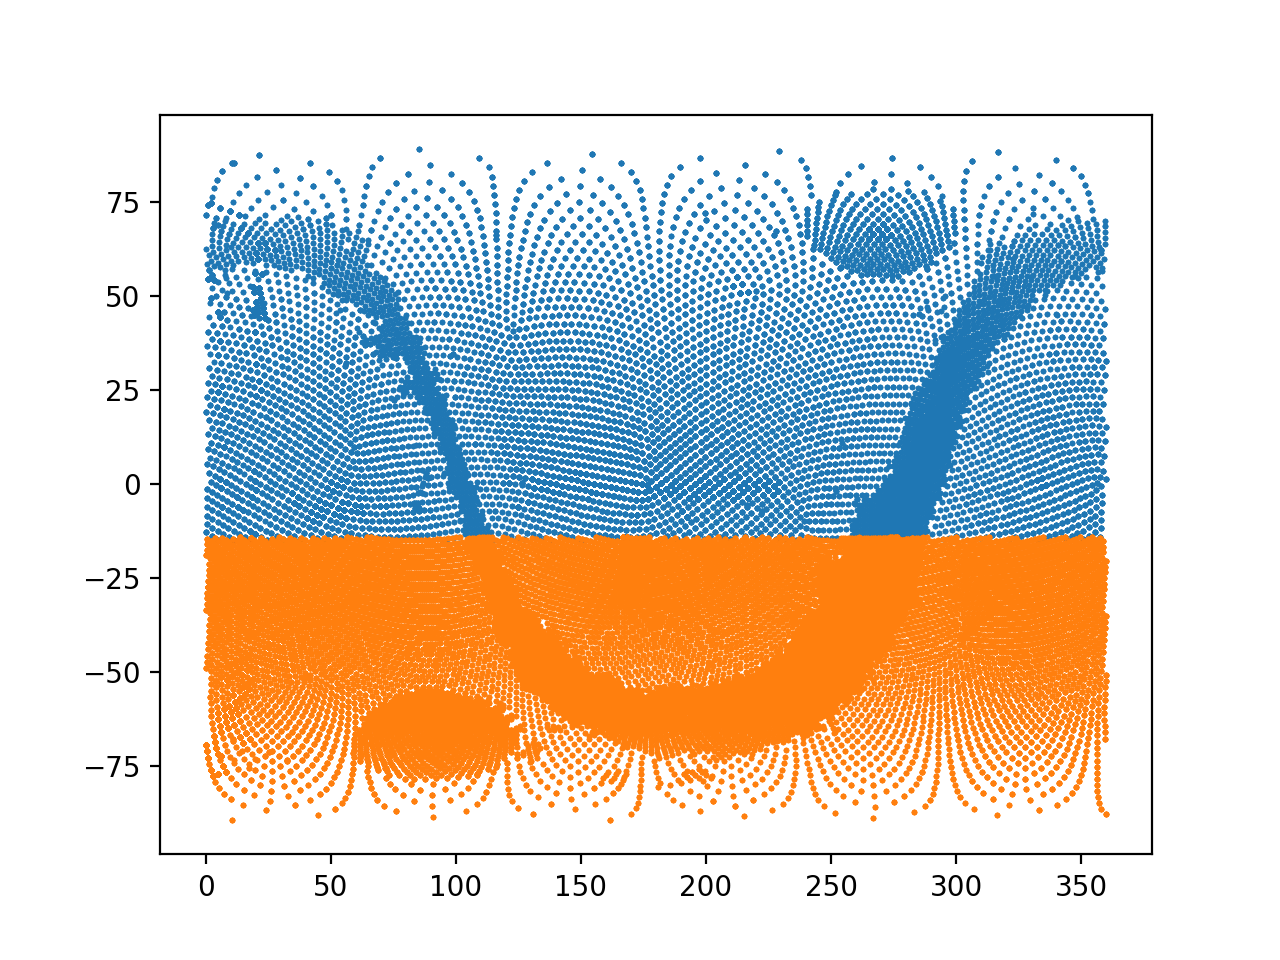

In [29]:
plt.scatter(ra_n, dec_n, s=1)
plt.scatter(ra_s, dec_s, s=1)

In [30]:
dtype_tiles = np.dtype([('racen', np.float64), ('deccen', np.float64),
                        ('tiletype', 'O')])
tiles_n = np.zeros(len(ra_n), dtype=dtype_tiles)
tiles_n['racen'] = ra_n
tiles_n['deccen'] = dec_n
tiles_n['tiletype'] = tiletype_n
tiles_s = np.zeros(len(ra_s), dtype=dtype_tiles)
tiles_s['racen'] = ra_s
tiles_s['deccen'] = dec_s
tiles_s['tiletype'] = tiletype_s

In [31]:
fitsio.write('straw-apo.fits', tiles_n, clobber=True)
fitsio.write('straw-lco.fits', tiles_s, clobber=True)